In [48]:
import pickle
import pandas as pd
import numpy as np

from pynyt import NYTArticleAPIObject
import requests
from bs4 import BeautifulSoup
from textblob import TextBlob
from collections import defaultdict

%matplotlib inline
import matplotlib.pyplot as plt

In [52]:
df_1987.to_pickle('df_1987.pickle')
df_2017.to_pickle('df_2017.pickle')

In [3]:
df_1987 = pd.read_pickle('df_1987.pickle')
df_2017 = pd.read_pickle('df_2017.pickle')

Whenever I visit home, I find a few hours to leaf through my parents' collection of old ('80s and '90s) National Geographic magazines. Although many of the magazine's advertisements are good for a quick laugh, I'm most fascinated by the longform articles—ambitious, sweeping stories spun across thirty pages or more, the product of many months of work for a writer-photographer team. The best of these articles succeed in distilling the essence of a place or culture into an hour's worth of text and images.

Reading these magazines has led to my developing an interest in the evolution of journalism. Over the years, these lengthy expositions seem to have fallen out of favor, replaced by shorter, more specific articles; in my mind, articles of over thirty pages are definitely a thing of the past. As a newcomer to the field of data science, I thought it would be interesting to verify my intuition using real data. I set out to obtain articles from the past and present, with the goal of making comparisons and determining if enough difference existed to build a predictive model - could a relatively simple model predict whether an article was written recently or not-so-recently?

Unfortunately, accessing National Geographic backlogs online requires a paid subscription. I quickly found an alternative in the New York Times, which allows free access (with daily limits) to its archives via the [Times Developer Network](https://developer.nytimes.com/). A variety of web APIs are provided, a few of which are very useful for combing lots of article data - I chose the Article Search API, which allows the user to narrow down a query using all of the extensive metadata fields. (An Article Search API key can be obtained at the above link.) A couple of Python wrappers do exist for the Article Search API, but none of them are actively maintained and I figured writing my own would be a good exercise, and a good opportunity to learn about the [requests](http://docs.python-requests.org/en/master/) library, among other things. My wrapper class can be found in pynyt.py—it worked very well for the purposes of this project, although there does seem to be a non-deterministic bug when making too many queries in a single notebook block.

In [5]:
miner = NYTArticleAPIObject('my api key is a secret! get your own! mine mine mine')

miner.get_usage()

994

`get_usage()` returns the number of API calls permitted for the day, the limit being 1000. (Calling the function also consumes a precious API call—a truly unfortunate necessity.) There are more limitations: a query can only return up to 1000 article results; if a query is too broad, results past the thousandth article will be cut off. Additionally, the results are returned 10 at a time, across up to 100 pages, and grabbing each page requires an API call.

For this project, these API limitations are inconsequential. I decided to grab 2,000 articles each from 2017 and 1987 - hopefully plenty for analysis and modeling, with more than half of my all-important API calls to spare. The Times publishes a wide variety of written material—in addition to traditional articles, material types include editorials, op-eds, columns, interviews, obituaries, and so forth. I wanted to limit this analysis to what I most readily associate with the New York Times: news stories written by Times reporters. The below queries pull 2,000 Times-sourced news articles each from the relevant years. Within a given year's results, 1,000 articles are from the foreign news desk and 1,000 are from the national news desk. This limitation is imposed with the additional goal of obtaining articles from 1987 and 2017 written about broadly similar topics (in order to focus the analysis and modeling on the style and conventions of the journalism itself, rather than the subject matter).

The code is split into four blocks to avoid the aforementioned bug, the exact cause of which I have yet to determine. The results are returned as a list of dictionaries, each entry being a page of query results (i.e. data for up to 10 articles). The responses are supposed to be ordered by relevancy, although in actuality I think all matching results are returned in order of recency of publication. Even in that case, 2,000 articles for a given year should make for a week or two's worth of news from around the world, which ought to be a diverse enough dataset for this purpose.

In [42]:
results_1987 = miner.query(fq = {'source': 'New York Times',
                                  'news_desk': 'Foreign',
                                  'type_of_material': 'News'},
                            begin_date = 19870101,
                            end_date = 19871231,
                            halt_overflow = False)


6796 articles were found
Processing page 0


/Users/sayed/Documents/0-Swarthmore/Projects/nyt-tech/pynyt.py:57: UserWarning: Only the first 1000 articles will be scraped, as per the API's paginator limit. Consider narrowing your search further (e.g. by date).
  warnings.warn(("Only the first 1000 articles will be scraped, as per the API's paginator limit. "


Processing page 1
Processing page 2
Processing page 3
Processing page 4
Processing page 5
Processing page 6
Processing page 7
Processing page 8
Processing page 9
Processing page 10
Processing page 11
Processing page 12
Processing page 13
Processing page 14
Processing page 15
Processing page 16
Processing page 17
Processing page 18
Processing page 19
Processing page 20
Processing page 21
Processing page 22
Processing page 23
Processing page 24
Processing page 25
Processing page 26
Processing page 27
Processing page 28
Processing page 29
Processing page 30
Processing page 31
Processing page 32
Processing page 33
Processing page 34
Processing page 35
Processing page 36
Processing page 37
Processing page 38
Processing page 39
Processing page 40
Processing page 41
Processing page 42
Processing page 43
Processing page 44
Processing page 45
Processing page 46
Processing page 47
Processing page 48
Processing page 49
Processing page 50
Processing page 51
Processing page 52
Processing page 53
Pr

In [43]:
results_1987 += miner.query(fq = {'source': 'New York Times',
                                 'news_desk': 'National',
                                 'type_of_material': 'News'},
                            begin_date = 19870101,
                            end_date = 19871231,
                            halt_overflow = False)

9702 articles were found
Processing page 0


/Users/sayed/Documents/0-Swarthmore/Projects/nyt-tech/pynyt.py:57: UserWarning: Only the first 1000 articles will be scraped, as per the API's paginator limit. Consider narrowing your search further (e.g. by date).
  warnings.warn(("Only the first 1000 articles will be scraped, as per the API's paginator limit. "


Processing page 1
Processing page 2
Processing page 3
Processing page 4
Processing page 5
Processing page 6
Processing page 7
Processing page 8
Processing page 9
Processing page 10
Processing page 11
Processing page 12
Processing page 13
Processing page 14
Processing page 15
Processing page 16
Processing page 17
Processing page 18
Processing page 19
Processing page 20
Processing page 21
Processing page 22
Processing page 23
Processing page 24
Processing page 25
Processing page 26
Processing page 27
Processing page 28
Processing page 29
Processing page 30
Processing page 31
Processing page 32
Processing page 33
Processing page 34
Processing page 35
Processing page 36
Processing page 37
Processing page 38
Processing page 39
Processing page 40
Processing page 41
Processing page 42
Processing page 43
Processing page 44
Processing page 45
Processing page 46
Processing page 47
Processing page 48
Processing page 49
Processing page 50
Processing page 51
Processing page 52
Processing page 53
Pr

In [44]:
results_2017 = miner.query(fq = {'source': 'New York Times',
                                 'news_desk': 'Foreign',
                                 'type_of_material': 'News'},
                           begin_date = 20170101,
                           halt_overflow = False)

3612 articles were found
Processing page 0


/Users/sayed/Documents/0-Swarthmore/Projects/nyt-tech/pynyt.py:57: UserWarning: Only the first 1000 articles will be scraped, as per the API's paginator limit. Consider narrowing your search further (e.g. by date).
  warnings.warn(("Only the first 1000 articles will be scraped, as per the API's paginator limit. "


Processing page 1
Processing page 2
Processing page 3
Processing page 4
Processing page 5
Processing page 6
Processing page 7
Processing page 8
Processing page 9
Processing page 10
Processing page 11
Processing page 12
Processing page 13
Processing page 14
Processing page 15
Processing page 16
Processing page 17
Processing page 18
Processing page 19
Processing page 20
Processing page 21
Processing page 22
Processing page 23
Processing page 24
Processing page 25
Processing page 26
Processing page 27
Processing page 28
Processing page 29
Processing page 30
Processing page 31
Processing page 32
Processing page 33
Processing page 34
Processing page 35
Processing page 36
Processing page 37
Processing page 38
Processing page 39
Processing page 40
Processing page 41
Processing page 42
Processing page 43
Processing page 44
Processing page 45
Processing page 46
Processing page 47
Processing page 48
Processing page 49
Processing page 50
Processing page 51
Processing page 52
Processing page 53
Pr

In [45]:
results_2017 += miner.query(fq = {'source': 'New York Times',
                                  'news_desk': 'National',
                                  'type_of_material': 'News'},
                            begin_date = 20170101,
                            halt_overflow = False)

3368 articles were found
Processing page 0


/Users/sayed/Documents/0-Swarthmore/Projects/nyt-tech/pynyt.py:57: UserWarning: Only the first 1000 articles will be scraped, as per the API's paginator limit. Consider narrowing your search further (e.g. by date).
  warnings.warn(("Only the first 1000 articles will be scraped, as per the API's paginator limit. "


Processing page 1
Processing page 2
Processing page 3
Processing page 4
Processing page 5
Processing page 6
Processing page 7
Processing page 8
Processing page 9
Processing page 10
Processing page 11
Processing page 12
Processing page 13
Processing page 14
Processing page 15
Processing page 16
Processing page 17
Processing page 18
Processing page 19
Processing page 20
Processing page 21
Processing page 22
Processing page 23
Processing page 24
Processing page 25
Processing page 26
Processing page 27
Processing page 28
Processing page 29
Processing page 30
Processing page 31
Processing page 32
Processing page 33
Processing page 34
Processing page 35
Processing page 36
Processing page 37
Processing page 38
Processing page 39
Processing page 40
Processing page 41
Processing page 42
Processing page 43
Processing page 44
Processing page 45
Processing page 46
Processing page 47
Processing page 48
Processing page 49
Processing page 50
Processing page 51
Processing page 52
Processing page 53
Pr

As illustrated [here](https://developer.nytimes.com/article_search_v2.json#/README) (scroll down to example responses), all sorts of metadata is returned, much of which I didn't think I would need to use. I was most interested in approaching this as a text classification study, so for a given article, all I really needed was the body of text and perhaps the headline and date. As it turned out, the responses do not contain the actual text of each article, so I also ended up having to grab each article's URL for scraping. These fields were loaded into another list of dictionaries for easy conversion to a Pandas dataframe shortly down the line.

(In the below function, I accidentally pull the source of the article as well, which is unneccessary given that the query results were limited to those from the New York Times.)

In [46]:
def results_to_list(results): # not a great name - results is a list of dicts too
    results_list = []
    for i in range(len(results)):
        for article in results[i]['response']['docs']:
            source = ''
            if 'source' in article:
                source = article['source']
            results_list.append({'date': article['pub_date'],
                            'headline': article['headline']['main'],
                            'web_url': article['web_url'],
                            'source': source})
    return results_list

list_1987 = results_to_list(results_1987)
list_2017 = results_to_list(results_2017)

At this point, since the queries take a little while (the Article Search API has a rate limit of one query per second), the results were pickled for when I need to close/reopen the notebook. Unfortunately, I decided to pickle the watered-down lists instead of the actual query results, so for this specific set of articles, a bunch of the (potentially useful) metadata is lost. Always save your raw data!

In [47]:
with open('list_1987.pickle', 'wb') as f:
    pickle.dump(list_1987, f)
with open('list_2017.pickle', 'wb') as f:
    pickle.dump(list_2017, f)

2000


In [2]:
with open('list_1987.pickle', 'rb') as f:
    list_1987 = pickle.load(f)
with open('list_2017.pickle', 'rb') as f:
    list_2017 = pickle.load(f)

In [11]:
df_1987 = pd.DataFrame(list_1987)
df_2017 = pd.DataFrame(list_2017)

df_1987.head()

,date,headline,source,web_url
0,1987-12-31T00:00:00Z,The Hills Are Not Alive With the Swoosh of Skis,The New York Times,https://www.nytimes.com/1987/12/31/world/the-h...
1,1987-12-31T00:00:00Z,Kabul Says a Convoy Breaks Siege of a City,The New York Times,https://www.nytimes.com/1987/12/31/world/kabul...
2,1987-12-31T00:00:00Z,Al Ghourayib Journal; And if the Nile Dries Up...,The New York Times,https://www.nytimes.com/1987/12/31/world/al-gh...
3,1987-12-31T00:00:00Z,Salvador Court Frees 2 Killers of Americans,The New York Times,https://www.nytimes.com/1987/12/31/world/salva...
4,1987-12-31T00:00:00Z,Rights Group Invited to Moscow For Week of Tal...,The New York Times,https://www.nytimes.com/1987/12/31/world/right...


With the data from the API queries loaded into dataframes, the next step was to scrape the text from each article and add it to the dataframes. This can be accomplished by using BeautifulSoup and inspecting New York Times article source code to find the right tags to search for. Looking at a few articles from 1987 and 2017, I determined that the text body was contained in paragraph tags with `itemprop='articleBody'` for 1987 articles and `class_='story-body-text story-content'` for 2017 articles. I wasn't sure if these were uniform conventions for the given years, and made sure to check for empty or very short strings (the result of a failure to find the right tags).

No problematic articles were encountered in the 1987 dataframe, but get_text() failed to obtain any text for several 2017 articles, as seen in the output below.

In [31]:
# DELETE ME? ????? ?

df_1987['text'] = ""
df_2017['text'] = ""
df_1987.set_value(0, 'text', 'hi')
df_1987.head()

,date,headline,source,web_url,text
0,1987-12-31T00:00:00Z,The Hills Are Not Alive With the Swoosh of Skis,The New York Times,https://www.nytimes.com/1987/12/31/world/the-h...,hi
1,1987-12-31T00:00:00Z,Kabul Says a Convoy Breaks Siege of a City,The New York Times,https://www.nytimes.com/1987/12/31/world/kabul...,
2,1987-12-31T00:00:00Z,Al Ghourayib Journal; And if the Nile Dries Up...,The New York Times,https://www.nytimes.com/1987/12/31/world/al-gh...,
3,1987-12-31T00:00:00Z,Salvador Court Frees 2 Killers of Americans,The New York Times,https://www.nytimes.com/1987/12/31/world/salva...,
4,1987-12-31T00:00:00Z,Rights Group Invited to Moscow For Week of Tal...,The New York Times,https://www.nytimes.com/1987/12/31/world/right...,


In [5]:
from bs4 import BeautifulSoup

df_1987['text'] = ""
df_2017['text'] = ""

def get_text(df):
    session = requests.Session()
    
    for i in range(len(df)):
        if i % 100 == 0:
            print('Processing url', i)
        url = df.iloc[i]['web_url']
        req = session.get(url)
        soup = BeautifulSoup(req.text)
        #paragraphs = soup.find_all('p', itemprop = 'articleBody') # 1987 articles
        paragraphs = soup.find_all('p', class_='story-body-text story-content') # 2017 articles

        txt = ''
        for p in paragraphs: # newlines for nice printing + paragraph analysis
            # txt += p.getText() # 1987 - newlines already written in
            txt += p.getText() + "\n" # 2017
        if len(txt) < 100:
            print("Problem with URL {}: {}".format(i, url))
        df.set_value(i, 'text', txt)
    
    return df

# df_1987 = get_text(df_1987)
df_2017 = get_text(df_2017)

Looking at the problematic articles, it's apparent that the issue arises from the articles possessing an unusual layout, perhaps for web-only presentation. The text is contained in paragraph tags with a very long class name, which will not be reproduced here! The articles are re-scraped using said class name and the lengths of each new text is printed to check whether the class name applies to all of the problematic articles. A reasonable number of words are thus found for each of the articles, so it looks like no further fixes are required.

In [101]:
print(df_1987.iloc[500]['text'])


                    WASHINGTON, Dec. 6— 
                    As the United States and the Soviet Union prepare for summit talks on a new treaty to reduce long-range arms, a debate is intensifying over whether the American proposal would increase or decrease the vulnerability of the U.S. nuclear forces.        
                    President Reagan campaigned for office in 1980 with a pledge to close the so-called ''window of vulnerability.'' According to this concept, the Soviet Union had a significant advantage because of its potential to destroy the American land-based missile force by using only part of its land-based missile force.        
                    Reagan Administration officials have argued that an agreement on deep cuts in long-range arms would produce a more stable strategic balance because it would compel the Soviet Union to reduce is force of land-based missiles. The Administration has said that those missiles are the most suitable weapons for carrying out an attack

In [52]:
df_1987.to_pickle('df_1987.pickle')
df_2017.to_pickle('df_2017.pickle')

In [3]:
df_1987 = pd.read_pickle('df_1987.pickle')
df_2017 = pd.read_pickle('df_2017.pickle')

In [22]:
# temp - remove when rerun above

problem_indices = []
for idx, article in df_2017.iterrows():
    length = len(article['text'])
    if length < 10:
        print('Length {} at URL {}: {}'.format(length, idx, article['web_url']))
        problem_indices.append(idx)
        
problem_indices

Length 0 at URL 896: https://www.nytimes.com/2017/06/16/world/canada/the-times-in-canada.html
Length 0 at URL 1264: https://www.nytimes.com/2017/07/21/us/politics/trump-communications-scaramucci-sanders.html
Length 0 at URL 1340: https://www.nytimes.com/2017/07/17/us/politics/trump-laws-bills.html
Length 0 at URL 1376: https://www.nytimes.com/2017/07/14/us/how-poems-inspire-pictures.html
Length 0 at URL 1398: https://www.nytimes.com/2017/07/12/us/politics/trump-russia-election-meeting.html
Length 0 at URL 1442: https://www.nytimes.com/2017/07/10/us/western-wildfires.html
Length 0 at URL 1472: https://www.nytimes.com/2017/07/07/us/politics/senate-hobbies.html
Length 0 at URL 1536: https://www.nytimes.com/2017/06/30/us/handmaids-protests-abortion.html
Length 0 at URL 1612: https://www.nytimes.com/2017/06/25/us/extreme-heat-scorches-southern-arizona.html


[896, 1264, 1340, 1376, 1398, 1442, 1472, 1536, 1612]

In [23]:
session = requests.Session()
p_class = "Paragraph-paragraph--2eXNE OakElement-paragraph--2e5h2 OakElement-left--2eGEj OakElement-toneFeature--uJSyt OakParagraph-headerHasNoLedeMedia--1Uoi7"
for idx in problem_indices:
    url = df_2017.iloc[idx]['web_url']
    req = session.get(url)
    soup = BeautifulSoup(req.text)
    paragraphs = soup.find_all('p', class_ = p_class)

    txt = ''
    for p in paragraphs:
        txt += p.getText() + "\n" # 2017
        
    print(len(txt.split()))
    
    df_2017.set_value(idx, 'text', txt)

/anaconda/envs/py3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html5lib"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /anaconda/envs/py3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "html5lib")

  markup_type=markup_type))


2919
4569
14312
10545
10371
3891
9564
5032
4024


Now that all the articles have been scraped, one of the initial questions—whether article length has changed over time—can be answered. This code adds columns to the dataframe for article length in words, as well as headline length, for good measure.

In [309]:
def get_length(text):
    return len(text.split())

df_1987['length'] = df_1987['text'].map(get_length)
df_2017['length'] = df_2017['text'].map(get_length)
df_1987['headline_length'] = df_1987['headline'].map(get_length)
df_2017['headline_length'] = df_2017['headline'].map(get_length)
display(df_1987.describe())
display(df_2017.describe())

,length,polarity,subjectivity,mean_sentence_length,num_paragraphs,mean_paragraph_length,headline_length
count,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,603.60700,0.054308,0.373114,23.949195,15.685000,38.142043,7.381000
std,326.77331,0.073908,0.095442,4.259242,7.924404,13.690003,2.433269
min,27.00000,-0.500000,0.000000,9.090909,1.000000,10.800000,1.000000
25%,324.00000,0.012960,0.325357,21.063497,9.000000,32.075549,6.000000
50%,631.00000,0.055558,0.379736,23.630604,16.000000,37.343137,7.000000
75%,857.25000,0.096405,0.428867,26.464493,21.000000,42.894737,9.000000
max,1361.00000,0.600000,1.000000,57.500000,44.000000,346.500000,25.000000


,length,polarity,subjectivity,mean_sentence_length,num_paragraphs,mean_paragraph_length,headline_length
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,965.439500,0.056852,0.387228,27.821021,23.463000,41.911288,9.963500
std,445.391875,0.055530,0.063004,5.003114,11.436653,7.812405,1.880674
min,41.000000,-0.198056,0.000000,9.175000,1.000000,11.250000,3.000000
25%,628.000000,0.023458,0.349520,24.435619,16.000000,37.071206,9.000000
50%,937.500000,0.058852,0.391664,27.482051,22.000000,41.525000,10.000000
75%,1240.000000,0.093797,0.427676,30.924015,29.000000,46.027564,11.000000
max,4569.000000,0.290000,0.594872,53.571429,117.000000,128.000000,19.000000


The results are quite suprising—article and headline length are both significantly longer today than in 1987, on average. Plotting the distributions might uncover some further insights:

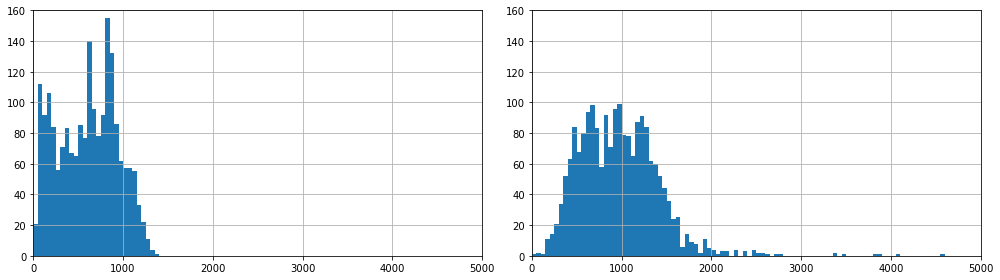

In [301]:
def plot_subplots(series, axis, my_color):
    axis.hist(series, bins=np.linspace(0, 5000, 101)) # bucket size of 50
    axis.set_ylim(0, 160)
    axis.set_xlim(0, 5000)
    axis.grid()

fig, axs = plt.subplots(1,2)
fig.set_size_inches(14, 4)

plot_subplots(df_1987['length'], axs[0], 'b')
plot_subplots(df_2017['length'], axs[1], 'r')
fig.tight_layout()

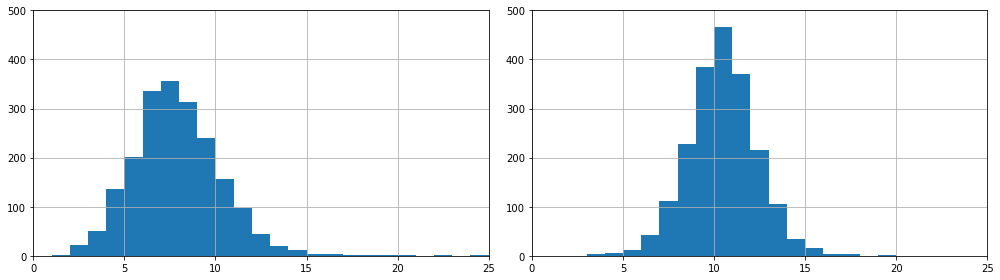

In [310]:
def plot_subplots(series, axis, my_color):
    axis.hist(series, bins=np.linspace(0, 25, 26)) # bucket size of 1
    axis.set_ylim(0, 500)
    axis.set_xlim(0, 25)
    axis.grid()

fig, axs = plt.subplots(1,2)
fig.set_size_inches(14, 4)

plot_subplots(df_1987['headline_length'], axs[0], 'b')
plot_subplots(df_2017['headline_length'], axs[1], 'r')
fig.tight_layout()

The distributions are quite different. The 1987 article length histogram seems roughly bimodal, with many of the articles being either very short (under 250 words) or of moderate length (500-1000 words). Relatively few articles of length greater than 1000 words are published. On the other hand, the distribution for 2017 appears to be closer to normal, albeit more strongly right-skewed. Articles below 250 words in length are nearly completely absent, and half or so of the articles appear to be at least 1000 words long.

The abundance of very short articles in the 1987 dataset is quite interesting. [Here's](https://www.nytimes.com/1987/12/28/world/new-zealand-fire-kills-3.html) the shortest article of them all—just one sentence long!

In [303]:
len_min_idx = df_1987['length'].argmin()
print(df_1987.iloc[len_min_idx]['length'])
print(df_1987.iloc[len_min_idx]['headline'])
print(df_1987.iloc[len_min_idx]['text'])
print(df_1987.iloc[len_min_idx]['web_url'])

27
New Zealand Fire Kills 3

                    AUCKLAND, New Zealand, Dec. 27— 
                    Fire destroyed a hotel today and killed three children in the town of Taneatua, 150 miles south of Auckland, the police said.        
https://www.nytimes.com/1987/12/28/world/new-zealand-fire-kills-3.html


Why might the distributions be so different? One factor could be that some of the long articles from 2017 are web-only publications, free of restrictions on length imposed by the print newspaper format. Finding an easy explanation for the decline of very short articles is a bit more difficult. It seems reasonable to attribute this change to an evolution in the Times's underlying protocols over time—articles of just a few sentences have simply fallen out of favor.

Another feature of potential interest is the average sentence length in a given article. Splitting at every period might not be the most intelligent way to go about this task, given the likely prevalence of abbreviations in these articles. The [TextBlob library](https://textblob.readthedocs.io/en/dev/), which provides a simple API for common NLP tasks, has functionality for splitting a text into sentences, so it's worth trying it out here. (I eventually move on to using nltk for modeling purposes, but since this is a first foray into NLP, TextBlob serves as a good starting point.)

In [118]:
def get_mean_sentence_length(text):
    sentences = TextBlob(text).sentences
    lengths = []
    for s in sentences:
        lengths.append(len(s.words))
    return sum(lengths) / len(lengths)

df_1987['mean_sentence_length'] = df_1987['text'].map(get_mean_sentence_length)
df_2017['mean_sentence_length'] = df_2017['text'].map(get_mean_sentence_length)
display(df_1987.describe())
display(df_2017.describe())

,length,polarity,subjectivity,mean_sentence_length,num_paragraphs,mean_paragraph_length
count,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,603.60700,0.054308,0.373114,23.949195,15.685000,38.142043
std,326.77331,0.073908,0.095442,4.259242,7.924404,13.690003
min,27.00000,-0.500000,0.000000,9.090909,1.000000,10.800000
25%,324.00000,0.012960,0.325357,21.063497,9.000000,32.075549
50%,631.00000,0.055558,0.379736,23.630604,16.000000,37.343137
75%,857.25000,0.096405,0.428867,26.464493,21.000000,42.894737
max,1361.00000,0.600000,1.000000,57.500000,44.000000,346.500000


,length,polarity,subjectivity,mean_sentence_length,num_paragraphs,mean_paragraph_length
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,965.439500,0.056852,0.387228,27.821021,23.463000,41.911288
std,445.391875,0.055530,0.063004,5.003114,11.436653,7.812405
min,41.000000,-0.198056,0.000000,9.175000,1.000000,11.250000
25%,628.000000,0.023458,0.349520,24.435619,16.000000,37.071206
50%,937.500000,0.058852,0.391664,27.482051,22.000000,41.525000
75%,1240.000000,0.093797,0.427676,30.924015,29.000000,46.027564
max,4569.000000,0.290000,0.594872,53.571429,117.000000,128.000000


With the advent of longer articles, sentences have actually gotten longer on average, too. Plotting the distributions might be interesting.

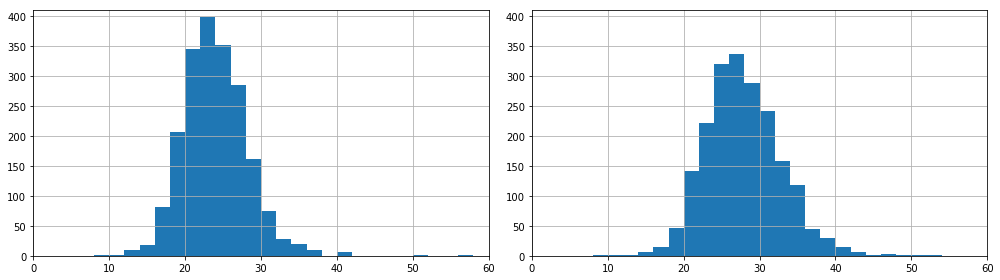

In [120]:
def plot_subplots(series, axis, my_color):
    axis.hist(series, bins=np.linspace(0, 60, 31)) # bucket size of 2
    axis.set_ylim(0, 410)
    axis.set_xlim(0, 60)
    axis.grid()

fig, axs = plt.subplots(1,2)
fig.set_size_inches(14, 4)

plot_subplots(df_1987['mean_sentence_length'], axs[0], 'b')
plot_subplots(df_2017['mean_sentence_length'], axs[1], 'r')
fig.tight_layout()

It looks like the 2017 distribution is a little bit broader, perhaps further indicating further stylistic freedoms in modern-day journalistic writing compared to the rigidities of old.

Sentiment analysis is another avenue of exploration for comparing these sets of articles. The polarity (-1.0 to 1.0, negative to positive) and subjectivity (0.0 to 1.0, objective to subjective) of a text can be obtained easily using TextBlob's sentiment analyzer. The polarity and subjectivity can be added to the dataframes as with the previous measures.

In [17]:
def get_polarity(text):
    return TextBlob(text).sentiment.polarity

def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

df_1987['polarity'] = df_1987['text'].map(get_polarity)
df_2017['polarity'] = df_2017['text'].map(get_polarity)

df_1987['subjectivity'] = df_1987['text'].map(get_subjectivity)
df_2017['subjectivity'] = df_2017['text'].map(get_subjectivity)

In [18]:
df_1987.describe()

,length,polarity,subjectivity
count,2000.000000,2000.000000,2000.000000
mean,4132.574500,0.054308,0.373114
std,2196.749994,0.073908,0.095442
min,207.000000,-0.500000,0.000000
25%,2280.250000,0.012960,0.325357
50%,4379.500000,0.055558,0.379736
75%,5821.000000,0.096405,0.428867
max,9185.000000,0.600000,1.000000


In [19]:
df_2017.describe()

,length,polarity,subjectivity
count,2000.000000,2000.000000,2000.000000
mean,5860.143000,0.056852,0.387228
std,2684.739854,0.055530,0.063004
min,257.000000,-0.198056,0.000000
25%,3855.750000,0.023458,0.349520
50%,5693.000000,0.058852,0.391664
75%,7488.250000,0.093797,0.427676
max,28138.000000,0.290000,0.594872


These sentiment measures are actually very similar between the two groups. Subjectivity in particular is surprisingly high (~0.4); for a news source to be only moderately objective seems unintuitive. There also appear to be some wacky outliers, as the maximum subjectivity value of 1.0 in df_1987 indicates. Looking at that particular article, it's quite short, which may contribute to the extreme value; nonetheless, nothing about the text itself seems amiss. If anything, the article appears to be quite objective.

In [101]:
max_subj = df_1987['subjectivity'].argmax()
te = (df_1987.iloc[max_subj]['text'])
print(te)
print(df_1987.iloc[max_subj]['subjectivity'])


                    BURLINGTON, Vt., Dec. 19— 
                    Look USA, a distributor of French-made alpine ski bindings, is recalling 13 models to fix a defect that could cause the binding to release unexpectedly, the company said Friday.        
                    Consumers were being asked to return the 30,000 bindings to authorized dealers for adjustment, a company spokesman said. The company had received complaints about the bindings but no injuries have been reported, he added.        
                    The models being recalled are ZRC, ZR, ZP, ZL, ZRJ, X-9, X-7, X-5, XH, XF, XFL, XG, XGR.        
1.0


To explore further, the text is broken up into individual words and the TextBlob sentiment analyzer is used to compute the subjectivity of each individual word:

In [116]:
subjs = defaultdict(set)

for word in te.split():
    sub = TextBlob(word).sentiment.subjectivity
    subjs[sub].add(word)

for sub in subjs:
    print('{}: {}\n'.format(sub, subjs[sub]))

0.0: {'ZL,', 'been', '30,000', 'about', 'Consumers', 'said', 'he', 'XGR.', 'bindings', 'added.', 'return', 'X-5,', 'Look', 'dealers', 'alpine', 'recalled', 'of', 'the', 'had', 'could', 'XFL,', 'defect', 'recalling', 'company', 'ZR,', 'for', 'received', 'release', 'ZP,', 'ZRJ,', 'X-7,', 'XG,', 'distributor', 'ski', 'said.', 'that', 'fix', 'authorized', 'are', 'a', 'no', 'Friday.', 'reported,', 'X-9,', 'to', 'spokesman', 'were', 'is', 'Dec.', '19—', 'cause', 'adjustment,', 'The', 'injuries', 'USA,', 'ZRC,', 'complaints', 'have', 'but', 'models', '13', 'asked', 'XF,', 'being', 'binding', 'French-made', 'bindings,', 'Vt.,', 'XH,', 'BURLINGTON,'}

1.0: {'unexpectedly,'}



It looks like the article falls on the other extreme—extremely objective! All but one of the words has a subjectivity score of 0.0, yet the single word with a score of 1.0 (fittingly, 'unexpectedly') completely throws off the overall score. Playing around with some test strings, it looks like the sentiment algorithm entirely ignores words with score 0.0 (a score assigned to many, many words). One has to believe that with cases like the above, this can't be intended behavior. I believe TextBlob uses a wrapper of the sentiment analyzer from the `pattern` library, where the problem may lay. As it stands, I am currently unfamiliar with said library's codebase—perhaps a project for next week....

In [114]:
print(TextBlob('hate').sentiment.subjectivity)

0.9


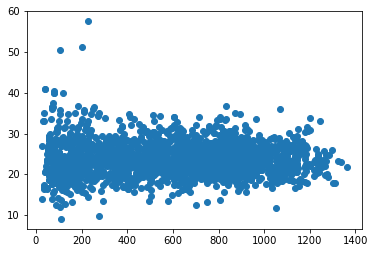

In [139]:
plt.scatter(df_1987['length'], df_1987['mean_sentence_length'])

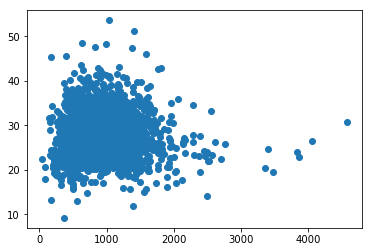

In [140]:
plt.scatter(df_2017['length'], df_2017['mean_sentence_length'])

In [43]:
df_1987.describe()

,length,polarity,subjectivity,mean_sentence_length
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,4132.574500,0.054308,0.373114,23.949195
std,2196.749994,0.073908,0.095442,4.259242
min,207.000000,-0.500000,0.000000,9.090909
25%,2280.250000,0.012960,0.325357,21.063497
50%,4379.500000,0.055558,0.379736,23.630604
75%,5821.000000,0.096405,0.428867,26.464493
max,9185.000000,0.600000,1.000000,57.500000


In [44]:
df_2017.describe()

,length,polarity,subjectivity,mean_sentence_length
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,5860.143000,0.056852,0.387228,27.821021
std,2684.739854,0.055530,0.063004,5.003114
min,257.000000,-0.198056,0.000000,9.175000
25%,3855.750000,0.023458,0.349520,24.435619
50%,5693.000000,0.058852,0.391664,27.482051
75%,7488.250000,0.093797,0.427676,30.924015
max,28138.000000,0.290000,0.594872,53.571429


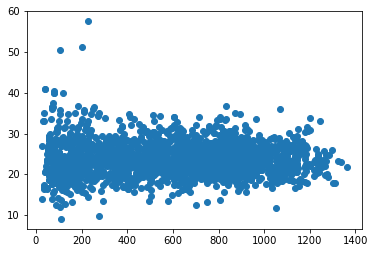

In [78]:
plt.scatter(df_1987['length'], df_1987['mean_sentence_length'])

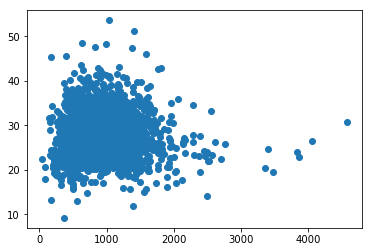

In [79]:
plt.scatter(df_2017['length'], df_2017['mean_sentence_length'])

In [83]:
def get_num_paragraphs(text):
    paragraphs = text.split('\n')
    for p in paragraphs:
        if len(p) == 0:
            paragraphs.remove(p)
    return len(paragraphs)

df_1987['num_paragraphs'] = df_1987['text'].map(get_num_paragraphs) # useless
df_2017['num_paragraphs'] = df_2017['text'].map(get_num_paragraphs)

df_1987['mean_paragraph_length'] = df_1987['length']/df_1987['num_paragraphs']
df_2017['mean_paragraph_length'] = df_2017['length']/df_2017['num_paragraphs']

In [117]:
display(df_1987.describe())
display(df_2017.describe())

,length,polarity,subjectivity,mean_sentence_length,num_paragraphs,mean_paragraph_length
count,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,603.60700,0.054308,0.373114,23.949195,15.685000,38.142043
std,326.77331,0.073908,0.095442,4.259242,7.924404,13.690003
min,27.00000,-0.500000,0.000000,9.090909,1.000000,10.800000
25%,324.00000,0.012960,0.325357,21.063497,9.000000,32.075549
50%,631.00000,0.055558,0.379736,23.630604,16.000000,37.343137
75%,857.25000,0.096405,0.428867,26.464493,21.000000,42.894737
max,1361.00000,0.600000,1.000000,57.500000,44.000000,346.500000


,length,polarity,subjectivity,mean_sentence_length,num_paragraphs,mean_paragraph_length
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,965.439500,0.056852,0.387228,27.821021,23.463000,41.911288
std,445.391875,0.055530,0.063004,5.003114,11.436653,7.812405
min,41.000000,-0.198056,0.000000,9.175000,1.000000,11.250000
25%,628.000000,0.023458,0.349520,24.435619,16.000000,37.071206
50%,937.500000,0.058852,0.391664,27.482051,22.000000,41.525000
75%,1240.000000,0.093797,0.427676,30.924015,29.000000,46.027564
max,4569.000000,0.290000,0.594872,53.571429,117.000000,128.000000


In [96]:
df_1987.to_pickle('df_1987.pickle')
df_2017.to_pickle('df_2017.pickle')

In [25]:
from random import shuffle
from textblob.classifiers import NaiveBayesClassifier
import nltk

train = []
test = []

for idx, row in df_1987.iterrows():
    tup = (row['headline'], '1987')
    if idx < 500:
        train.append(tup)
    elif idx < 750:
        test.append(tup)
        
for idx, row in df_2017.iterrows():
    tup = (row['headline'], '2017')
    if idx < 500:
        train.append(tup)
    elif idx < 750:
        test.append(tup)
        
shuffle(train)
shuffle(test)

In [205]:
all_headlines = []
for h in df_1987['headline']:
    all_headlines.append((h, '1987'))
for h in df_2017['headline']:
    all_headlines.append((h, '2017'))

tokenizer = nltk.RegexpTokenizer(r'\w+')

pos_bigrams = []
pos_trigrams = []
for h in all_headlines:
    tokenized = tokenizer.tokenize(h[0].lower())
    pos_tagged = nltk.pos_tag(tokenized)
    for i in range(len(pos_tagged) - 1):
        pos_bigrams.append((pos_tagged[i][1], pos_tagged[i+1][1]))
        '''if i == len(pos_tagged) - 2:
            break
        pos_trigrams.append((pos_tagged[i][1], pos_tagged[i+1][1], pos_tagged[i+2][1]))'''

In [210]:
all_bigrams = nltk.FreqDist(pos_bigrams)
common_bigrams_list = list(all_bigrams.most_common())[:300]
bigram_features = [b[0] for b in common_bigrams_list]

print(len(bigram_features))

avoid = [('RB', 'CC'), ('CC', 'VBD')]
for a in avoid:
    if a in bigram_features:
        bigram_features.remove(a)

all_trigrams = nltk.FreqDist(pos_trigrams)
common_trigrams_list = list(all_trigrams.most_common())[:800]
trigram_features = [b[0] for b in common_trigrams_list]
print(len(all_bigrams))
len(bigram_features)

300
474


298

In [251]:
def get_ngram_features(headline):
    features = {}
    tokenized = tokenizer.tokenize(headline.lower())
    pos_tagged = nltk.pos_tag(tokenized)
    
    headline_bigrams = []
    for i in range(len(pos_tagged) - 1):
        headline_bigrams.append((pos_tagged[i][1], pos_tagged[i+1][1]))
        
    for b in bigram_features:
        features['contains {}'.format(b)] = b in headline_bigrams
    '''
    headline_trigrams = []
    for i in range(len(pos_tagged) - 2):
        headline_trigrams.append((pos_tagged[i][1], pos_tagged[i+1][1], pos_tagged[i+2][1]))
        
    for b in trigram_features:
        features['contains {}'.format(b)] = b in headline_trigrams'''
        
    return features

In [252]:
#print(list(all_bigrams.most_common()))

featuresets = [(get_ngram_features(h), y) for (h,y) in all_headlines]
shuffle(featuresets)

In [178]:
train, test = featuresets[:1600], featuresets[1600:]

#classifier = nltk.DecisionTreeClassifier.train(train)

In [109]:
nltk.classify.accuracy(classifier, test)

0.62

In [179]:
classifier2 = nltk.NaiveBayesClassifier.train(train)

In [180]:
nltk.classify.accuracy(classifier2, test)

0.6833333333333333

In [181]:
classifier2.show_most_informative_features(15)

Most Informative Features
  contains ('WP', 'VBD') = True             2017 : 1987   =     11.8 : 1.0
  contains ('CC', 'VBD') = True             2017 : 1987   =      7.7 : 1.0
 contains ('VBD', 'VBN') = True             2017 : 1987   =      5.7 : 1.0
  contains ('WRB', 'NN') = True             2017 : 1987   =      5.0 : 1.0
   contains ('VB', 'VB') = True             2017 : 1987   =      4.6 : 1.0
   contains ('IN', 'RB') = True             2017 : 1987   =      4.4 : 1.0
   contains ('RP', 'JJ') = True             2017 : 1987   =      4.4 : 1.0
  contains ('VBN', 'RP') = True             2017 : 1987   =      4.4 : 1.0
   contains ('JJ', 'MD') = True             2017 : 1987   =      4.4 : 1.0
  contains ('VB', 'PRP') = True             2017 : 1987   =      4.4 : 1.0
  contains ('JJR', 'NN') = True             2017 : 1987   =      4.4 : 1.0
  contains ('WP', 'VBZ') = True             2017 : 1987   =      3.7 : 1.0
  contains ('RB', 'PRP') = True             2017 : 1987   =      3.7 : 1.0

In [272]:
shuffle(featuresets)
train, test = featuresets[:3000], featuresets[3000:]
classifier3 = nltk.NaiveBayesClassifier.train(train)
nltk.classify.accuracy(classifier3, test)

0.713

In [273]:
classifier3.show_most_informative_features(40)

Most Informative Features
  contains ('JJS', 'CD') = True             2017 : 1987   =     10.9 : 1.0
 contains ('VB', 'PRP$') = True             2017 : 1987   =      9.5 : 1.0
 contains ('VBG', 'PRP') = True             2017 : 1987   =      6.9 : 1.0
   contains ('JJ', 'VB') = True             2017 : 1987   =      6.2 : 1.0
  contains ('WP', 'VBD') = True             2017 : 1987   =      5.8 : 1.0
  contains ('RB', 'PRP') = True             2017 : 1987   =      5.6 : 1.0
  contains ('TO', 'VBG') = True             2017 : 1987   =      4.9 : 1.0
  contains ('RBR', 'JJ') = True             2017 : 1987   =      4.9 : 1.0
 contains ('PRP', 'VBP') = True             2017 : 1987   =      4.7 : 1.0
   contains ('JJ', 'RB') = True             2017 : 1987   =      4.7 : 1.0
   contains ('NN', 'WP') = True             2017 : 1987   =      4.6 : 1.0
  contains ('PRP', 'IN') = True             2017 : 1987   =      4.5 : 1.0
 contains ('VBP', 'PRP') = True             2017 : 1987   =      4.5 : 1.0

In [1]:
for h in all_headlines:
    pos_bigrams = []
    tokenized = tokenizer.tokenize(h[0].lower())
    pos_tagged = nltk.pos_tag(tokenized)
    for i in range(len(pos_tagged) - 1):
        pos_bigrams.append((pos_tagged[i][1], pos_tagged[i+1][1]))
    feat = ('WP', 'VBD')
    if feat in pos_bigrams:
        idx = pos_bigrams.index(feat)
        sp = tokenized
        sp[idx] = sp[idx].upper()
        sp[idx+1] = sp[idx+1].upper()
        print('{}: {}'.format(h[1], ' '.join(sp)))

NameError: name 'all_headlines' is not defined

In [194]:
len(all_headlines)

4000

In [274]:
from nltk.metrics.scores import precision, recall
from collections import defaultdict

refsets = defaultdict(set)
testsets = defaultdict(set)

for i, (feats, year) in enumerate(test):
    refsets[year].add(i)
    observed = classifier3.classify(feats)
    testsets[observed].add(i)

In [275]:
print('1987 precision:', precision(refsets['1987'], testsets['1987']))
print('1987 recall:', recall(refsets['1987'], testsets['1987']))
print('2017 precision:', precision(refsets['2017'], testsets['2017']))
print('2017 recall:', recall(refsets['2017'], testsets['2017']))

1987 precision: 0.708411214953271
1987 recall: 0.7431372549019608
2017 precision: 0.7182795698924731
2017 recall: 0.6816326530612244


In [271]:
len(bigram_features)

298

In [278]:
all_articles = []
for h in df_1987['text']:
    all_articles.append((h, '1987'))
for h in df_2017['text']:
    all_articles.append((h, '2017'))

tokenizer = nltk.RegexpTokenizer(r'\w+')

art_pos_bigrams = []
for a in all_articles:
    tokenized = tokenizer.tokenize(a[0].lower())
    pos_tagged = nltk.pos_tag(tokenized)
    for i in range(len(pos_tagged) - 1):
        art_pos_bigrams.append((pos_tagged[i][1], pos_tagged[i+1][1]))
        '''if i == len(pos_tagged) - 2:
            break
        pos_trigrams.append((pos_tagged[i][1], pos_tagged[i+1][1], pos_tagged[i+2][1]))'''

In [280]:
art_all_bigrams = nltk.FreqDist(art_pos_bigrams)
art_common_bigrams_list = list(art_all_bigrams.most_common())[:300]
art_bigram_features = [b[0] for b in art_common_bigrams_list]

print(len(art_all_bigrams))
len(art_bigram_features)

958


300

In [285]:
def get_art_ngram_features(article):
    features = {}
    tokenized = tokenizer.tokenize(article.lower())
    pos_tagged = nltk.pos_tag(tokenized)
    
    article_bigrams = set()
    for i in range(len(pos_tagged) - 1):
        article_bigrams.add((pos_tagged[i][1], pos_tagged[i+1][1]))
        
    for b in art_bigram_features:
        features['contains {}'.format(b)] = b in article_bigrams
    '''
    headline_trigrams = []
    for i in range(len(pos_tagged) - 2):
        headline_trigrams.append((pos_tagged[i][1], pos_tagged[i+1][1], pos_tagged[i+2][1]))
        
    for b in trigram_features:
        features['contains {}'.format(b)] = b in headline_trigrams'''
        
    return features

In [286]:
#print(list(all_bigrams.most_common()))

art_featuresets = [(get_art_ngram_features(h), y) for (h,y) in all_articles]
shuffle(art_featuresets)

In [287]:
shuffle(art_featuresets)
train, test = art_featuresets[:3000], art_featuresets[3000:]
classifier4 = nltk.NaiveBayesClassifier.train(train)
nltk.classify.accuracy(classifier4, test)

0.638

In [288]:
classifier4.show_most_informative_features(40)

Most Informative Features
   contains ('IN', 'JJ') = False            1987 : 2017   =     45.4 : 1.0
  contains ('NN', 'NNS') = False            1987 : 2017   =     36.1 : 1.0
  contains ('NNS', 'IN') = False            1987 : 2017   =     29.9 : 1.0
   contains ('NN', 'CC') = False            1987 : 2017   =     28.4 : 1.0
  contains ('VBN', 'IN') = False            1987 : 2017   =     19.2 : 1.0
  contains ('VBD', 'IN') = False            1987 : 2017   =     12.9 : 1.0
  contains ('JJ', 'NNS') = False            1987 : 2017   =      8.8 : 1.0
  contains ('VBD', 'DT') = False            1987 : 2017   =      8.5 : 1.0
   contains ('TO', 'VB') = False            1987 : 2017   =      7.4 : 1.0
  contains ('IN', 'NNS') = False            1987 : 2017   =      6.6 : 1.0
   contains ('VB', 'DT') = False            1987 : 2017   =      6.5 : 1.0
 contains ('PRP', 'VBD') = False            1987 : 2017   =      5.8 : 1.0
   contains ('NN', 'DT') = False            1987 : 2017   =      5.7 : 1.0

In [292]:
count_87 = 0
count_17 = 0

for h in all_articles:
    pos_bigrams = set()
    tokenized = tokenizer.tokenize(h[0].lower())
    pos_tagged = nltk.pos_tag(tokenized)
    for i in range(len(pos_tagged) - 1):
        pos_bigrams.add((pos_tagged[i][1], pos_tagged[i+1][1]))
    feat = ('IN', 'JJ')
    if feat in pos_bigrams:
        if h[1] == '1987':
            count_87 += 1
        else:
            count_17 += 1
        '''
        idx = pos_bigrams.index(feat)
        sp = tokenized
        sp[idx] = sp[idx].upper()
        sp[idx+1] = sp[idx+1].upper()
        print('{}: {}'.format(h[1], ' '.join(sp[idx-5:idx+5])))'''

In [293]:
print(count_87, count_17)

1906 1999


In [274]:
from nltk.metrics.scores import precision, recall
from collections import defaultdict

refsets = defaultdict(set)
testsets = defaultdict(set)

for i, (feats, year) in enumerate(test):
    refsets[year].add(i)
    observed = classifier3.classify(feats)
    testsets[observed].add(i)

In [275]:
print('1987 precision:', precision(refsets['1987'], testsets['1987']))
print('1987 recall:', recall(refsets['1987'], testsets['1987']))
print('2017 precision:', precision(refsets['2017'], testsets['2017']))
print('2017 recall:', recall(refsets['2017'], testsets['2017']))

1987 precision: 0.708411214953271
1987 recall: 0.7431372549019608
2017 precision: 0.7182795698924731
2017 recall: 0.6816326530612244
